<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from   sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-14 10:40:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  19.4KB/s    in 1.2s    

2020-04-14 10:40:25 (19.4 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

Define a function to get the data from a csv file, and to remove dummy columns (with name Unnamed)

In [3]:
def get_data(file):
    """
    Get the data from a data file in csv format
    """
    
    df = pd.read_csv(file)
    cols_to_drop = [] # list with column names to remove
    # 1st check that the columns names are in the data
    cols_to_test = ['Unnamed: 0','Unnamed: 0.1']
    for col in cols_to_test:
        if col in df.columns:
            cols_to_drop.append(col)
            
    if cols_to_drop:
        df.drop(columns=cols_to_drop,axis=1,inplace=True)
    
    return df


In [4]:
df = get_data('loan_train.csv')
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 8)

In [6]:
# Will use the copy (df_for_fit) for later when training the data
# Will use df to explore the data
df_for_fit = df.copy()
df_for_fit.shape

(346, 8)

### Convert to date time object 

In [7]:
df['due_date']       = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Let’s start by looking the 1-D distributions of the variables in the data-set.
I am first going to define what is the target, numerical variables and categorical variables. 
I am excluding the datatime variables.

In [118]:
# Definition of target, numeric and categorical variables
target   = "loan_status"
num_vars = ["Principal","age"]
cat_vars = ["terms","education","Gender"]

Let's first define a function for plotting the distribution of categorical variables (including the target)

In [126]:
def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def cat_vars_dist_plot(var_counts,
                       figsize = (10,8),
                       wi      = 0.45,
                       color   = 'b'
                      ):
    """
    function for bar plotting of categorical variables
    """

    labels      = list(var_counts.index)
    values      = list(var_counts.values)
    values_frac = list(100*var_counts.values/var_counts.values.sum())

    x     = np.arange(len(labels))  # the label locations
    width = wi  # the width of the bars

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    idx = 0
    rects = ax[idx].bar(x, values, width,color=color)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_ylabel('Occurences')
    ax[idx].set_title(var_counts.name + ' distribution')
    ax[idx].set_xticks(x)
    ax[idx].set_xticklabels(labels)
    # ax.legend()
    autolabel(rects,ax[idx])

    idx = 1
    rects = ax[idx].bar(x, values_frac, width,color=color)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_ylabel('Fraction Occurences (%)')
    ax[idx].set_title(var_counts.name + ' distribution')
    ax[idx].set_xticks(x)
    ax[idx].set_xticklabels(labels)
    # ax.legend()
    autolabel(rects,ax[idx])

    fig.tight_layout()

    plt.show()
    

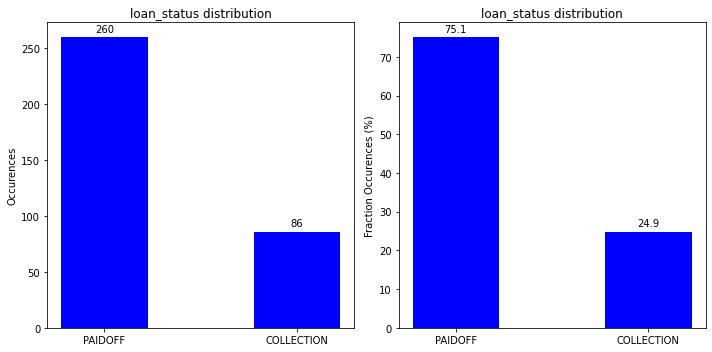

In [127]:
# Loot at the target
target_counts = df[target].value_counts()
cat_vars_dist_plot(var_counts = target_counts,
                   figsize    = (10,5),
                   wi         = 0.45)

260 people (75.1 %) have paid off the loan on time while 86 (24.9 %) have gone into collection.

Let's now look rest of the categorical variables in the data-set.

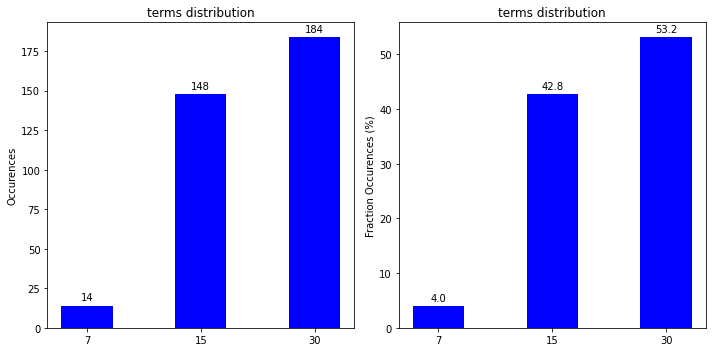

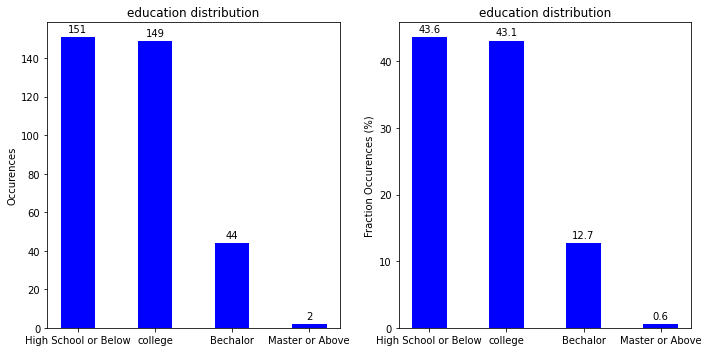

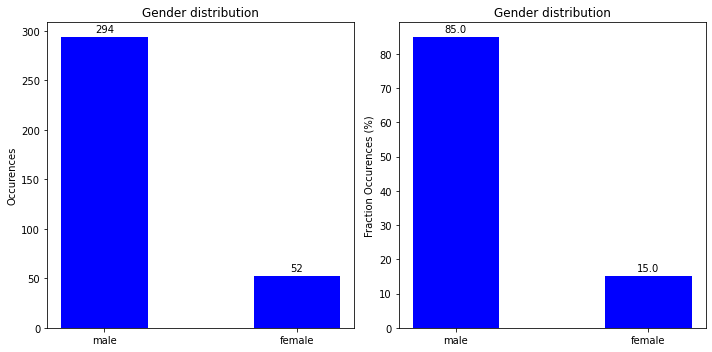

In [128]:
for col in cat_vars:
    var_counts = df[col].value_counts()
    if df[col].dtype != "object":
        var_counts = var_counts.sort_index(ascending = True)
        
    cat_vars_dist_plot(var_counts = var_counts,
                       figsize    = (10,5),
                       wi         = 0.45)
    

We can see that
 * Most of the people (96 %) apply for loans with terms of 15 and 30 days.
 * Almost half of the applicants (43.6 %) have a low level of education.
 * Most of the applicants (85 %) are men.

Lets now define a function for plotting the numeric variables

In [101]:
def num_vars_dist_plot(df,
                       var_name,
                       nbins   = 10,
                       figsize = (10,5),
                       color   = 'b',
                       alpha   = 0.7,
                      ):
    """
    function for hist plotting of numeric variables
    """
    
    xmin,xmax = df[var_name].min(),df[var_name].max()
    
    percent   = 0.0001
    delta     = xmax - xmin
    xmin     -= percent*delta
    xmax     += percent*delta

    bins = np.linspace(xmin, xmax, nbins+1) 
    
    porcent = 0.05
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    idx = 0
    n,_,_ = ax[idx].hist(x       = df[var_name],
                         bins    = bins,
                         color   = color,
                         alpha   = alpha,
                         density = False,
                        )
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_xlim([bins[0],bins[-1]])
    ax[idx].set_ylim([0,np.max(n)*(1.0 + porcent)])
    ax[idx].set_xlabel(var_name)
    ax[idx].set_ylabel('Occurences')
    ax[idx].set_title(var_name + ' distribution')
    
    weights = (100/df[var_name].shape[0])*np.ones(df[var_name].shape[0])
    
    idx = 1
    n,_,_ = ax[idx].hist(x       = df[var_name],
                         bins    = bins,
                         color   = color,
                         alpha   = alpha,
                         density = False,
                         weights = weights,
                        )
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_xlim([bins[0],bins[-1]])
    ax[idx].set_ylim([0,np.max(n)*(1.0 + porcent)])
    ax[idx].set_xlabel(var_name)
    ax[idx].set_ylabel('Fractional occurrances (%)')
    ax[idx].set_title(var_name + ' distribution')

    fig.tight_layout()

    plt.show()

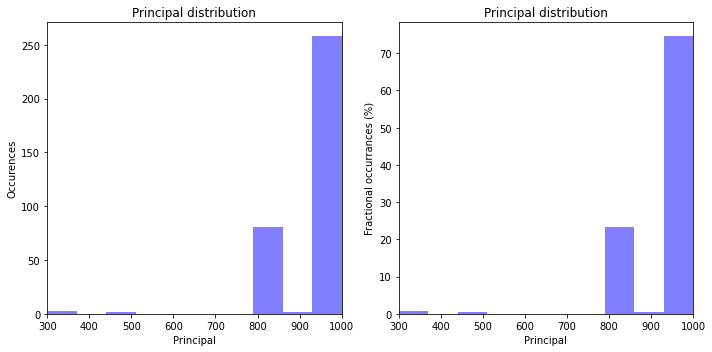

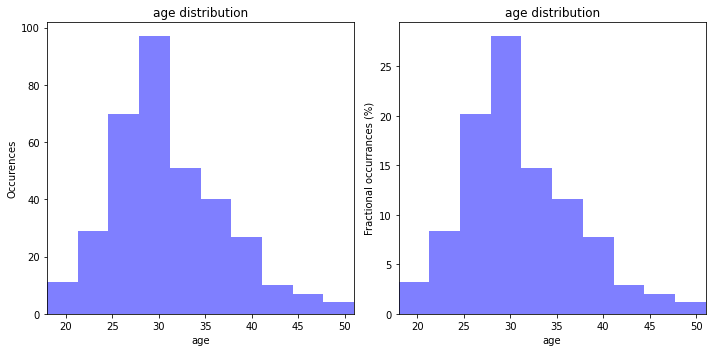

In [103]:
# Plot the distribution of the numerical variables
for col in num_vars:
    num_vars_dist_plot(df = df,
                       var_name = col,
                       nbins   = 10,
                       figsize = (10,5),
                       color   = 'b',
                       alpha   = 0.5,
                      )

We observe that:
* Most of of the loan applications are for amounts above 800 $
* The applicant are relatively young, with a median value around 30 years old

Lets now understand better the correlations amoung the variables. For this lets define 
a set of functions for visualization.

In [113]:
def do_scatter_plot(df,
                    var_name_x,
                    var_name_y,
                    figsize = (10,5),
                    color   = 'b',
                    marker  = 'o',
                   ):
    """
    function for scatter plotting of numeric vs numeric variables
    """
    
    percent   = 0.05
    xmin,xmax = df[var_name_x].min(),df[var_name_x].max()
    delta     = xmax - xmin
    xmin     -= percent*delta
    xmax     += percent*delta
    
    ymin,ymax = df[var_name_y].min(),df[var_name_y].max()
    delta     = ymax - ymin
    ymin     -= percent*delta
    ymax     += percent*delta
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    ax.scatter(x = df[var_name_x],
               y = df[var_name_y],
               color   = color,
               marker  = marker,
              )
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    ax.set_xlabel(var_name_x)
    ax.set_ylabel(var_name_y)
    ax.set_title(var_name_x + " vs " + var_name_y + ' distribution')

    fig.tight_layout()

    plt.show()
    

In [123]:
# Function to explore categorical variables and correlations with the target
def plot_box(df,
             cat_var,
             num_var,
             figsize,
             fontsize):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
            
    # sns.boxplot(x=cat_var, y=num_var, data=df,order=order)
    sns.boxplot(x=cat_var, y=num_var, data=df)
    ax.set_xlabel(cat_var, fontsize=fontsize)
    ax.set_ylabel(num_var, fontsize=fontsize)
    
    plt.show()
    

In [261]:
def limit_ratio(p,z,M):
    rrr  = p
    rrr += z**2/(2*M)
    rrr += z*np.sqrt((p*(1 - p)/M) + (z**2/(4*M**2)))
    rrr /= 1 + z**2/M
    
    return rrr

In [283]:
# Function to explore categorical variables and correlations with the target
def plot_box2(df,
              cat_var,
              num_var,
              nbins,
              figsize,
              fontsize):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    idx = 0
    percent   = 0.01
    xmin,xmax = df[num_var].min(),df[num_var].max()
    delta     = xmax - xmin
    xmin     -= percent*delta
    xmax     += percent*delta
    
    bins = np.linspace(xmin, xmax, nbins+1) 
    
    levels = list(df[cat_var].unique())
    colors = ['b','r','g','m']
    
    percent = 0.05
    
    nmax = -1.0e+20
    occs = []
    for i,lev in enumerate(levels):
        cond = df[cat_var] == lev
        n,_,_ = ax[idx].hist(x       = df.loc[cond,num_var],
                             bins    = bins,
                             color   = colors[i],
                             alpha   = 0.5,
                             density = True,
                             label   = lev,
                            )
        occs.append(n)
        if nmax < np.max(n):
            nmax = np.max(n)
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_xlim([bins[0],bins[-1]])
    ax[idx].set_ylim([0,nmax*(1.0 + percent)])
    ax[idx].set_xlabel(num_var)
    ax[idx].set_ylabel('Norm occurences')
    ax[idx].set_title(num_var + ' distribution vs ' + cat_var)
    ax[idx].legend()
    
    idx = 1
    the_label = levels[0]
    xs         = []
    weights    = []
    weights_ep = []
    weights_em = []
    for i in range(len(bins)-1):
        xs.append(0.5*(bins[i] + bins[i+1]))
        
        cond = (df[num_var] >= bins[i]) & (df[num_var] < bins[i+1])
        Nd = df[cond].shape[0]
        cond = cond & (df[cat_var] == labels[0])
        Nn = df[cond].shape[0]
        
        w = Nn
        if Nd > 0:
            w /= Nd
        
        wep = 0.0
        wem = 0.0
        if Nd > 0:
            wep = limit_ratio(p=w,z=+1,M=Nd)
            wem = limit_ratio(p=w,z=-1,M=Nd)
            
        wep = np.abs(wep - w)
        wem = np.abs(wem - w)
                    
        w   *= 100.0
        wep *= 100.0
        wem *= 100.0
        
        #print("w = {} +{}-{}, M = {}".format(w,wep,wem,Nd))
        
        weights.append(w)
        weights_ep.append(wep)
        weights_em.append(wem)
             
    ax[idx].errorbar(x    = np.array(xs),
                     y    = np.array(weights),
                     yerr = [np.array(weights_em),np.array(weights_ep)],
                     capsize = 3,
                     fmt  = "bo",
                     linewidth  = 3,
                     elinewidth = 2,
                     capthick   = 3,
                     markersize = 6,
                    )
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_xlim([bins[0],bins[-1]])
    ax[idx].set_ylim([0,110.0])
    ax[idx].set_xlabel(num_var)
    ax[idx].set_ylabel(the_label + ' Frac' + ' (%)')
    ax[idx].set_title(the_label + ' faction vs ' + num_var)    
    
    idx = 2
    # sns.boxplot(x=cat_var, y=num_var, data=df,order=order)
    sns.boxplot(x=cat_var, y=num_var, data=df)
    ax[idx].set_xlabel(cat_var, fontsize=fontsize)
    ax[idx].set_ylabel(num_var, fontsize=fontsize)
    
    plt.show()
    

In [195]:
def cat_vars_cor_plots(df,
                       var_name1,
                       var_name2,
                       figsize = (10,8),
                       wi      = 0.45,
                      ):

    labels1 = list(df[var_name1].unique())
    labels2 = list(df[var_name2].unique())

    var_name_x   = None
    var_name_hue = None
    if len(labels1) >= len(labels2):
        var_name_x   = var_name1
        var_name_hue = var_name2
    else:
        var_name_x   = var_name2
        var_name_hue = var_name1

    labels_hue = list(df[var_name_hue].unique())
    labels     = list(df[var_name_x].unique())

    values      = []
    values_frac = []
    for hue in labels_hue:
        tmp_list = []
        for lab in labels:
            cond = (df[var_name_hue] == hue) & (df[var_name_x] == lab)
            n = df[cond].shape[0]
            tmp_list.append(n)
        values.append(tmp_list)
    
    values_tot  = []
    for lab in labels:
        cond = df[var_name_x] == lab
        n = df[cond].shape[0]
        values_tot.append(n)
        
    for i,hue in enumerate(labels_hue):
        tmp_list = []
        for j,fff in enumerate(values[i]):
            tmp_list.append(100*fff/values_tot[j])
        values_frac.append(tmp_list)
        
    width_tot = wi
    width     = width_tot/len(labels_hue)
    if len(labels_hue) == 1:
        shifts = [0]
    else:
        hhh = (len(labels_hue) - 1)/2
        shifts = list(np.linspace(-hhh*width, +hhh*width, len(labels_hue)))

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
                     
    idx = 0
    rects = []
    for i,hue in enumerate(labels_hue):
        rects.append(  ax[idx].bar(x + shifts[i], values[i], width, label=hue)  )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_ylabel('Occurrences')
    ax[idx].set_title('Occurrences by ' + var_name_x + ' and ' + var_name_hue)
    ax[idx].set_xticks(x)
    ax[idx].set_xticklabels(labels)
    ax[idx].legend()
    
    for i,hue in enumerate(labels_hue):
        autolabel(rects[i],ax[idx])
        
    idx = 1
    rects = []
    for i,hue in enumerate(labels_hue):
        rects.append(  ax[idx].bar(x + shifts[i], values_frac[i], width, label=hue)  )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[idx].set_ylabel('Frac Occurrence (%)')
    ax[idx].set_title('Occurrences by ' + var_name_x + ' and ' + var_name_hue)
    ax[idx].set_xticks(x)
    ax[idx].set_xticklabels(labels)
    ax[idx].legend()
    
    for i,hue in enumerate(labels_hue):
        autolabel(rects[i],ax[idx])

    fig.tight_layout()

    plt.show()
    

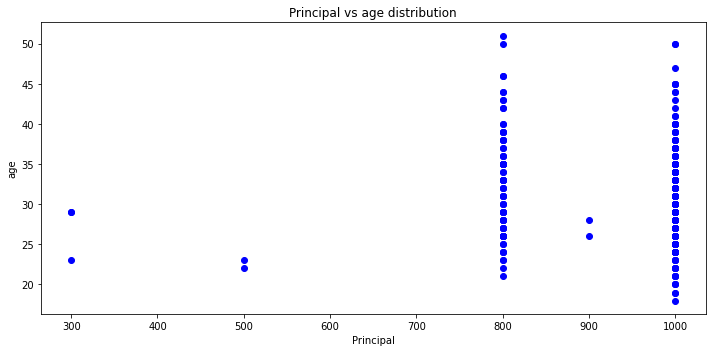

In [114]:
for i in range(len(num_vars)):
    for j in range(len(num_vars)):
        if i >= j:
            continue
        
        do_scatter_plot(df = df,
                        var_name_x = num_vars[i],
                        var_name_y = num_vars[j],
                        figsize = (10,5),
                        color   = 'b',
                        marker  = 'o',
                       )
            

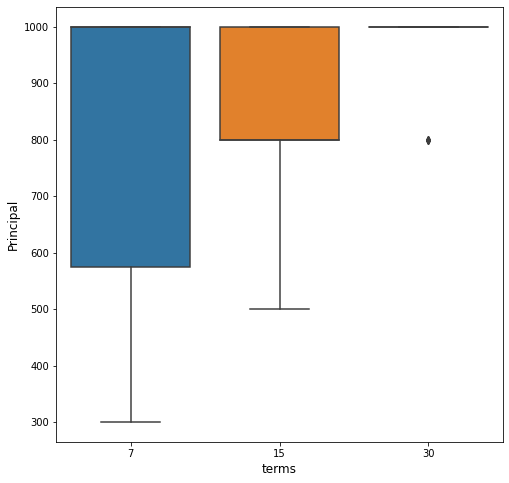

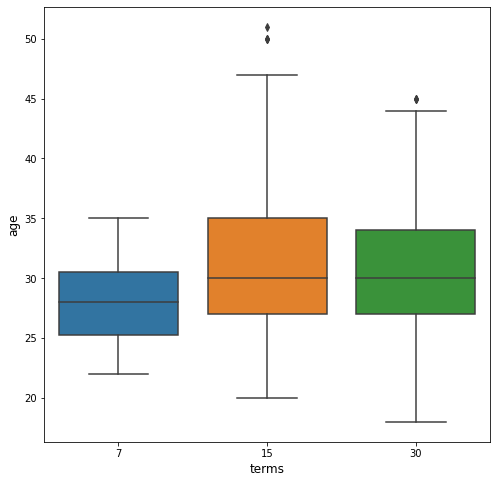

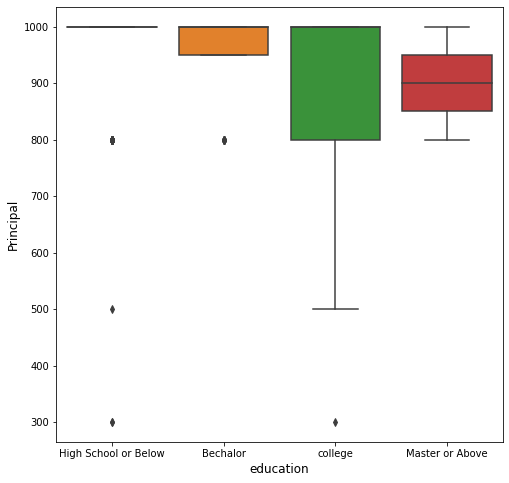

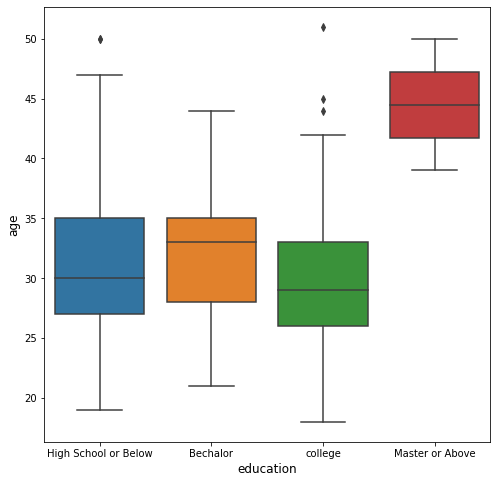

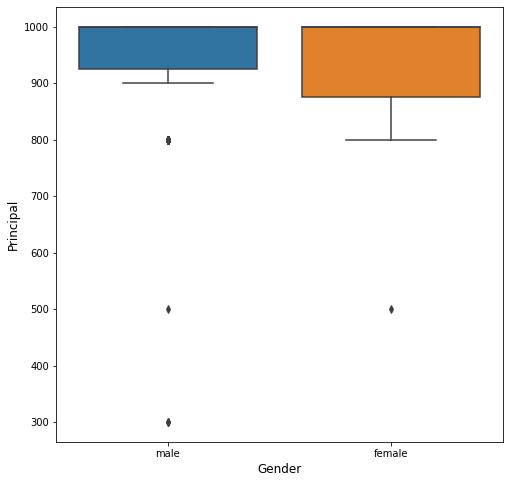

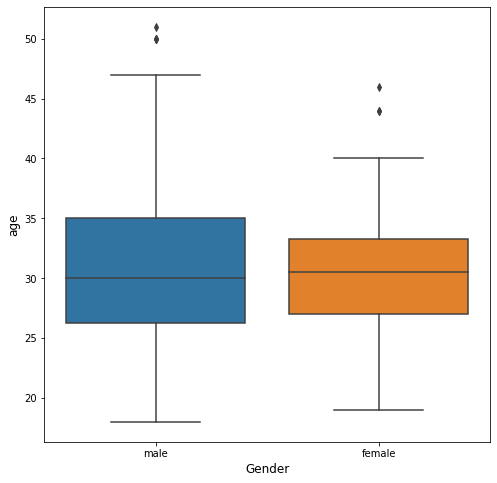

In [124]:
for col_cat in cat_vars:
    for col_num in num_vars:
            
        plot_box(df = df,
                 cat_var = col_cat,
                 num_var = col_num,
                 figsize = (8,8),
                 fontsize = 12)

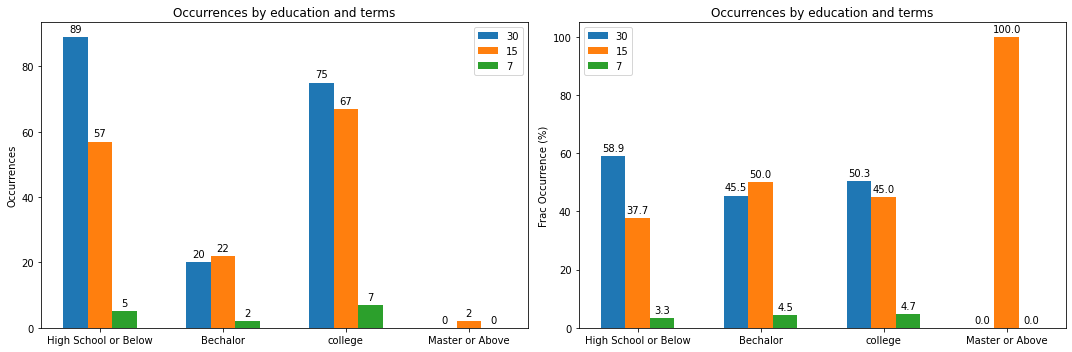

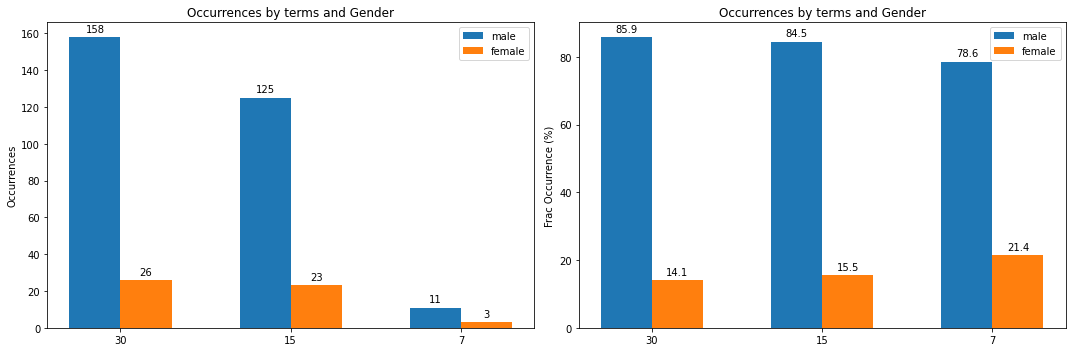

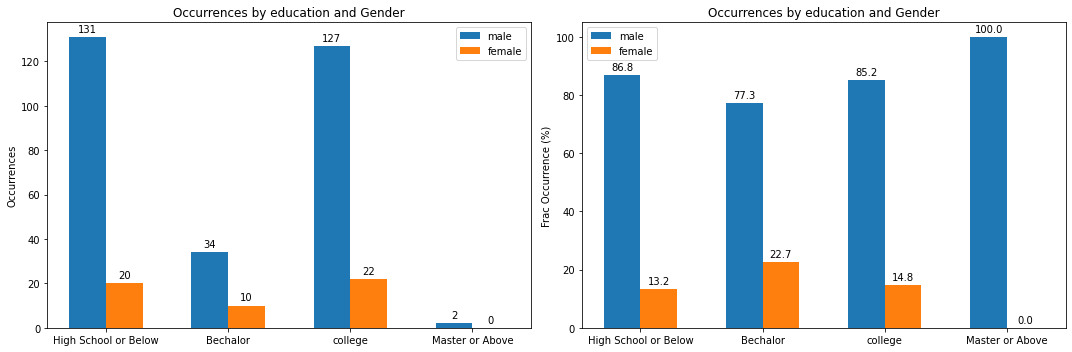

In [197]:
for i,col1 in enumerate(cat_vars):
    for j,col2 in enumerate(cat_vars):
        if i >= j:
            continue
        
        cat_vars_cor_plots(df = df,
                           var_name1 = col1,
                           var_name2 = col2,
                           figsize = (15,5),
                           wi      = 0.6,
                          )

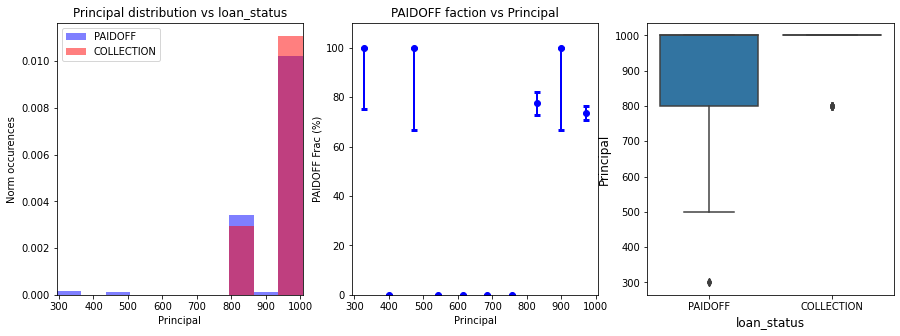

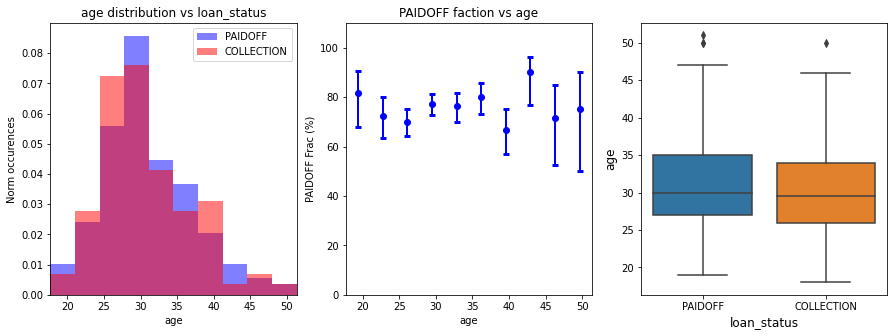

In [284]:
for col_num in num_vars:
    plot_box2(df = df,
              cat_var = target,
              num_var = col_num,
              nbins   = 10,
              figsize = (15,5),
              fontsize = 12)

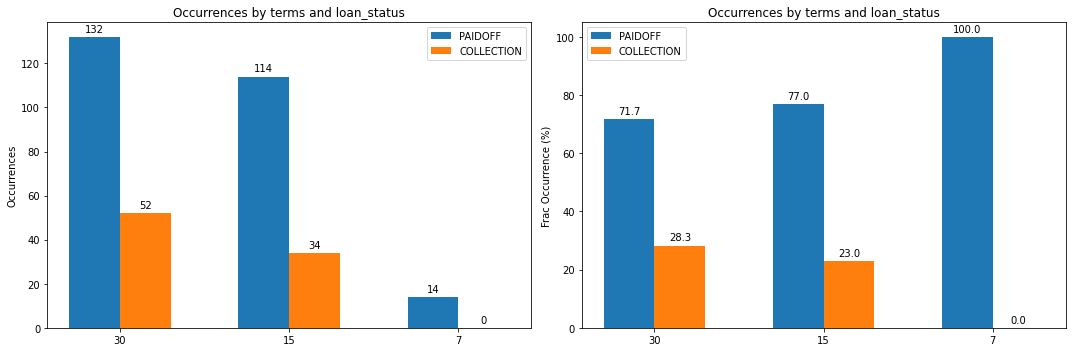

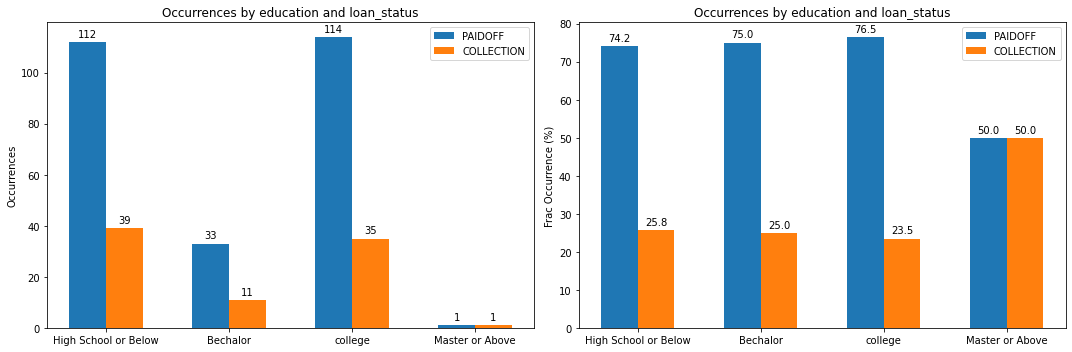

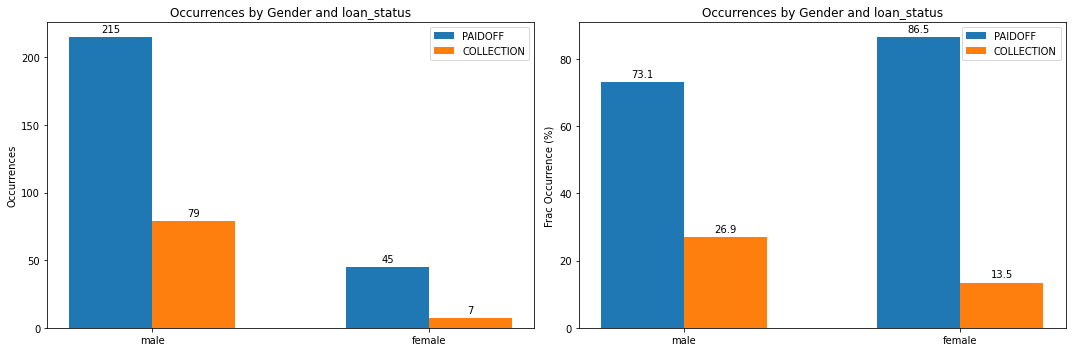

In [200]:
for col in cat_vars:
    cat_vars_cor_plots(df = df,
                       var_name1 = col,
                       var_name2 = target,
                       figsize = (15,5),
                       wi      = 0.6,
                      )

Lets plot some columns to underestand data better:

In [ ]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

In [ ]:
import seaborn as sns

In [ ]:
def nice_plot(df,
              x_var,
              minmax = None,
              col = 'Gender',
              hue = 'loan_status',
              pos_label = 'PAIDOFF',
              anbins = 10,
              afigsize    = (7,3),
              afontsize   = 6,
             ):
    
    nbins      = anbins
    figsize    = afigsize
    fontsize   = afontsize

    # x_var = "Principal"
    xmin    = None
    xmax    = None
    percent = 0.001
    if minmax is None:
        xmin,xmax = df[x_var].min(),df[x_var].max()
    else:
        xmin,xmax = minmax
        percent   = 0.0
        nbins     = int(xmax - xmin)
        
    delta     = xmax - xmin
    xmin     -= percent*delta
    xmax     += percent*delta

    bins = np.linspace(xmin, xmax, nbins+1)
    g = sns.FacetGrid(df, col=col, hue=hue, palette="Set1", col_wrap=2)
    g.map(plt.hist, x_var, bins=bins, ec="k")

    g.axes[-1].legend()
    plt.show()


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    gender_list = list(df[col].unique())
    for idx,gen in enumerate(gender_list):
        x_values = []
        y_values = []
        for i in range(len(bins)-1):
            cond_x    = (df[x_var] >= bins[i]) & (df[x_var] < bins[i+1])
            cond_good = df[hue] == pos_label
            cond_gend = df[col] == gen
            cond_all= cond_x & cond_gend
            x_values.append(0.5*(bins[i] + bins[i+1]))
            Ngood = df[(cond_all) & (cond_good)].shape[0]
            Nall  = df[(cond_all)].shape[0]
            if Nall == 0:
                y_values.append(-1)
            else:
                y_values.append(100*Ngood/Nall)

        ax[idx].errorbar(x = np.array(x_values),
                         y = np.array(y_values),
                         yerr = 0,
                         fmt  = "bo",
                         linewidth  = 3,
                         markersize = 4,
                        )

        ax[idx].set_xlim([bins[0],bins[-1]])
        ax[idx].set_ylim([0,110])
        ax[idx].set_xlabel(x_var, fontsize=fontsize)
        ax[idx].set_ylabel(pos_label + ' frac (%)', fontsize=fontsize)
        ax[idx].set_title(col + ' = ' + gen, fontsize=fontsize)

    plt.show()
    

In [ ]:
nice_plot(df = df,
          x_var = "Principal",
          minmax = None,
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

In [ ]:
nice_plot(df = df,
          x_var = "age",
          minmax = None,
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

It doesn't seem to be a correlation between the age and the likelihood of paying a loan

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

In [ ]:
nice_plot(df = df,
          x_var = "dayofweek",
          minmax = (0.0-0.5,6+0.5),
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

### Lets look at the day of the week when people have to pay the loan 

In [ ]:
df['dayofweek_pay'] = df['due_date'].dt.dayofweek

In [ ]:
nice_plot(df = df,
          x_var = "dayofweek_pay",
          minmax = (0.0-0.5,6+0.5),
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

It seems that people miss to pay the loan when the due date is either the begining of the week or the weekend

### Visualizing the time people have  to paye the loan

In [ ]:
factor_sec_to_days = 1./(24*3600.)
df['time_to_pay_days'] = (df['due_date'] - df['effective_date']).dt.total_seconds()*factor_sec_to_days
df.head()

In [ ]:
nice_plot(df = df,
          x_var = "time_to_pay_days",
          minmax = None,
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

In [ ]:
ggg = df['time_to_pay_days'].unique()
print(ggg)

In [ ]:
nice_plot(df = df,
          x_var = "terms",
          minmax = None,
          col = 'Gender',
          hue = 'loan_status',
          pos_label = 'PAIDOFF',
          anbins = 10,
          afigsize    = (7,3),
          afontsize   = 8)

In [ ]:
ggg = df['terms'].unique()
print(ggg)

In [ ]:
df['due_time_o_terms'] = ((df['time_to_pay_days']+1)/df['terms'])

In [ ]:
figsize    = (7,3)
fontsize   = 8
    
x_var = 'due_time_o_terms'
y_var = 'time_to_pay_days'

xmin,xmax = df[x_var].min(),df[x_var].max()
ymin,ymax = df[y_var].min(),df[y_var].max()

percent   = 0.01
delta     = xmax - xmin
xmin     -= percent*delta
xmax     += percent*delta

delta     = ymax - ymin
ymin     -= percent*delta
ymax     += percent*delta
ymin      = 0.0

# bins = np.linspace(xmin, xmax, nbins+1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
gender_list = list(df['Gender'].unique())
for idx,gen in enumerate(gender_list):
    cond = df['Gender'] == gen
    ax[idx].scatter(x = df.loc[cond,x_var],
                    y = df.loc[cond,y_var],
                    c = 'b',
                    # linewidth  = 3,
                    # markersize = 4,
                   )

    ax[idx].set_xlim([xmin,xmax])
    ax[idx].set_ylim([ymin,ymax])
    ax[idx].set_xlabel(x_var, fontsize=fontsize)
    ax[idx].set_ylabel(y_var, fontsize=fontsize)
    ax[idx].set_title('Gender = ' + gen, fontsize=fontsize)

plt.show()

It seems that longer the due time for paying the loan, less likely are the people able to pay it.  
Lets look at the correlation between Principal and time_to_pay_days.

In [ ]:
figsize    = (7,3)
fontsize   = 8
    
x_var = 'Principal'
y_var = 'time_to_pay_days'

xmin,xmax = df[x_var].min(),df[x_var].max()
ymin,ymax = df[y_var].min(),df[y_var].max()

percent   = 0.01
delta     = xmax - xmin
xmin     -= percent*delta
xmax     += percent*delta

delta     = ymax - ymin
ymin     -= percent*delta
ymax     += percent*delta
ymin      = 0.0

# bins = np.linspace(xmin, xmax, nbins+1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
gender_list = list(df['Gender'].unique())
for idx,gen in enumerate(gender_list):
    cond = df['Gender'] == gen
    ax[idx].scatter(x = df.loc[cond,x_var],
                    y = df.loc[cond,y_var],
                    c = 'b',
                    # linewidth  = 3,
                    # markersize = 4,
                   )

    ax[idx].set_xlim([xmin,xmax])
    ax[idx].set_ylim([ymin,ymax])
    ax[idx].set_xlabel(x_var, fontsize=fontsize)
    ax[idx].set_ylabel(y_var, fontsize=fontsize)
    ax[idx].set_title('Gender = ' + gen, fontsize=fontsize)

plt.show()

## Convert Categorical features to numerical values

Lets look at gender:

In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


How about education?

In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

It seems that there isn't a big correlation with the education level

# Install some libraries to be used when building the estimator pipelines 

In [ ]:
# !conda update setuptools

In [ ]:
# notice: installing dask-ml might takes a few minutes
# !conda install -c anaconda dask-ml=0.12.0 -y

In [ ]:
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler

## Automatise preprocessing
Put all the global preprocessing steps into a single function

In [ ]:
def do_global_preprocessing(df):
    """ 
    This function sumarizes all the global preprocessing steps defined in the cells above 
    for exploration data analysis (data cleaning and feature engineering)
    """
    
    # Copy the data
    df_copy = df.copy()
    
    # Convert data columns to datatime format
    data_cols = [c for c in df_copy.columns if "date" in c]
    for col in data_cols:
        df_copy[col] = pd.to_datetime(df_copy[col])
    
    # Generate the dayofweek feature
    df_copy['dayofweek'] = df_copy['effective_date'].dt.dayofweek
    
    # Generate the weekend feature
    df_copy['weekend'] = df_copy['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    
    # Generate the dayofweek_pay feature
    df_copy['dayofweek_pay'] = df_copy['due_date'].dt.dayofweek
    # Generate the middle_week_pay feature
    df_copy['middle_week_pay'] = df_copy['dayofweek_pay'].apply(lambda x: 1 if (x == 0 or x>3)  else 0)
    
    # Generate the time_to_pay_days feature
    # This is the time the clients have to pay the loan, i.e due_date - effective_data
    factor_sec_to_days = 1./(24*3600.)
    df_copy['time_to_pay_days'] = (df_copy['due_date'] - df_copy['effective_date']).dt.total_seconds()*factor_sec_to_days
    
    # Convert the target to binary variable
    df_copy['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
    
    return df_copy
    

In [ ]:
# Show the data previous to the global preprocessing
df_for_fit.head()

In [ ]:
# Preprocess the data and show it
df_for_fit_prep = do_global_preprocessing(df_for_fit)
df_for_fit_prep.head()

In [ ]:
# Now define the training data, serparating the predictors and the target
X_train = df_for_fit_prep
y_train = X_train.pop("loan_status")

### Feature selection

Lets define a class sklearn pipeline compatible to select the features for model training

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Select a list of features from data

    parameters:
    -----------
      columns: str or list of str, list of columns to select
    """

    def __init__(self, columns=None):
        # list of columns specified to be selected
        self.columns = columns

    def get_cols(self,X):
        """ Build the list of columns to select """

        cols = []
        # check if the list of columns specified by the user is in data list of columns
        if self.columns is None:
            return cols

        cols = list(set(X.columns).intersection(set(self.columns)))

        return cols

    def fit(self, X, y=None):
        # Add the possibility to give as input a string instead of a list
        if isinstance(self.columns,list):
            pass
        elif isinstance(self.columns,str):
            # if the input is a string converted to the list with a single element
            self.columns = [self.columns]
        else:
            raise ValueError("FeatureSelector (fit): columns parameter has to be either a string or a list of strings.")

        self.selected_columns = self.get_cols(X)
            
        return self

    def transform(self, X, y=None):
        if len(self.selected_columns) == 0:
            # If selected columns is empy do nothing
            return X
        else:
            # Use only the columns in the data in the selected_columns list
            return  X.loc[:,self.selected_columns]
    

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Preprocessing pipeline

Will start by defining a couple of functions to be used in the process of model optimization, which is grid-search CV

The function below counts the number of parameters combinations that are going to be tested during grid-search CV

In [ ]:
def count_number_of_fits(grid_params):
    """
    Count the number of parameter combinations to be tested during grid-search CV
    
    parameters
    ----------
       grid_params: a dictionary with the grid values of the parameters
    """
    
    nfits = 1
    for k,v in grid_params.items():
        nfits *= len(v)
        
    return nfits


The function below prints out a summary of the grid-search CV optimization process

In [ ]:
def  summary_results(gscv,name):
    """
    Print summary of results from grid search CV
    """
    
    msg = '\n{0:-^31}\n'.format('Summary {}'.format(name))

    cv_res = gscv.cv_results_
    
    row = gscv.best_index_

    # print best estimator metrics
    msg += '\n{0:>20s}\n'.format('# Metrics of best estimator:')
    msg += '{0:_>35}\n'.format('')

    msg += '{0:>20s}:{1:>10d}\n'.format('Estimator index',row)
    
    param_refit_scorer = gscv.get_params().get('refit')
    if type(param_refit_scorer) is str:
        msg += '{0:>20s}:{1:>10s}\n'.format('Refit scorer',param_refit_scorer)

    refit_time_value = gscv.refit_time_
    suffix = 'sec'
    msg += '{0:>20s}:{1:>10.5f}{2:>4s}\n'.format('Refit time',refit_time_value,suffix)
    
    suffix = 'sec'
    msg += '{0:>20s}:{1:>10.5f}{2:>4s}\n'.format('mean_fit_time', cv_res.get('mean_fit_time')[row],suffix)
    msg += '{0:>20s}:{1:>10.5f}{2:>4s}\n'.format('std_fit_time',  cv_res.get('std_fit_time')[row],suffix)
    
    scorings = gscv.get_params().get('scoring')    
    if type(scorings) == str:
        scorings = [scorings]
        
    for score in scorings:
        suffix = ''
        par_name = 'mean_test_' + score
        msg += '{0:>20s}:{1:>10.5f}{2:>4s}\n'.format(par_name, cv_res.get(par_name)[row],suffix)
        par_name = 'std_test_' + score
        msg += '{0:>20s}:{1:>10.5f}{2:>4s}\n'.format(par_name, cv_res.get(par_name)[row],suffix)
        
    msg += '{0:_>35}\n'.format('')
    msg += '\n'

    # print best hyperparamters values
    params = gscv.best_params_
    msg += '\n{0:>20s}\n'.format('# Parameters of best estimator:')
    msg += '{0:_>91}\n'.format('')
    for k,v in params.items():
        msg += '{0:>70s}:{1:>20s}\n'.format(k,str(v))
    msg += '{0:_>91}\n'.format('')

    msg += '\n'
    msg += '{0:_>91}\n'.format('')
    # print the best estimator pipeline steps
    msg += '\n{0:>20s}\n'.format('# Best estimator pipeline steps:')
    for step in gscv.best_estimator_.steps:
        msg += '{}\n'.format(str(step))
    msg += '{0:_>91}\n'.format('')
    msg += '\n'

    print(msg)

The parameters below define the grid-search CV configuration
 * Will select the best fit as the one with maximum f1-score

In [ ]:
import sklearn


In [ ]:
# metrics to track
scorings = ['roc_auc','f1','accuracy','recall','precision']
# metric to select the best model
refit    = 'f1'
# k-fold CV
cv       = 5
# verbosity
verbose  = 3

balance_data = False

In there we define a set of preprocessing steps for treating the data before training the final classifier  
Will define a pipeline with the preprocessing steps

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Preprocessing pipeline
preprocessing = Pipeline([('feature_selector', FeatureSelector()), # Select the features to use
                          ('categorizer',      Categorizer()),     # Apply categoriation to the categorical variables
                          ('dummyencorer',     DummyEncoder()),    # Apply on-hot-encoding to the categorical variables
                          ('standard_scaler',  StandardScaler()),  # Apply standard scaler to all the variables
                         ])

# Define grid of preprocessing parameters to use in the process of GridSearchCV
preprocessing_grid = {'feature_selector__columns':  [['Principal','education','Gender','weekend'],
                                                     ['Principal','education','Gender','weekend','time_to_pay_days'],
                                                     ['Principal','education','Gender','weekend','middle_week_pay'],
                                                     ['Principal','education','Gender','weekend','middle_week_pay','time_to_pay_days'],
                                                    ],
                      'dummyencorer__drop_first':   [True,False],
                     }

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Take the preprocessing pipeline and add at the end the KNN classifier
pipeline_list = preprocessing.steps.copy()
pipeline_list.append(('knn',KNeighborsClassifier()))

knn_estimator = Pipeline(pipeline_list)
print(knn_estimator)

# Add the corresponding parameters to the parameters grid
knn_grid_params = preprocessing_grid.copy()
knn_grid_params['knn__n_neighbors'] = [1,2,3,4,5,6,8,10,15]
print(knn_grid_params)

# print the number of fits to do
nparams = count_number_of_fits(knn_grid_params)
nfits   = nparams*cv
print("# params combinations to test = {}, nfits = {}".format(nparams,nfits))

In [ ]:
# Define the grid-searchCV object
knn_gsCV = GridSearchCV(estimator  = knn_estimator,
                        param_grid = knn_grid_params,
                        scoring    = scorings,
                        refit      = refit,
                        cv         = cv,
                        verbose    = verbose
                       )

In [ ]:
# Now launch the grid-searchCV optimization
knn_gsCV.fit(X_train,y_train)

In [ ]:
# Print the summary of the results
summary_results(knn_gsCV,"knn_classifier")

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Take the preprocessing pipeline and add at the end the Decision Tree classifier
pipeline_list = preprocessing.steps.copy()
pipeline_list.append(('decision_tree',DecisionTreeClassifier()))

decision_tree_estimator = Pipeline(pipeline_list)
print(decision_tree_estimator)

# Add the corresponding parameters to the parameters grid
decision_tree_grid_params = preprocessing_grid.copy()
decision_tree_grid_params['decision_tree__criterion']    = ['entropy']
# decision_tree_grid_params['decision_tree__max_depth']    = [2,3,5,8,10,15,20]
decision_tree_grid_params['decision_tree__max_depth']    = [5,10,15,20,25,30]
decision_tree_grid_params['decision_tree__random_state'] = [123456]

if balance_data:
    decision_tree_grid_params['decision_tree__class_weight'] = ['balanced']
else:
    decision_tree_grid_params['decision_tree__class_weight'] = [None]

decision_tree_grid_params['decision_tree__max_features'] = ['auto']
print(decision_tree_grid_params)

# print the number of fits to do
nparams = count_number_of_fits(decision_tree_grid_params)
nfits   = nparams*cv
print("# params combinations to test = {}, nfits = {}".format(nparams,nfits))

In [ ]:
decision_tree_gsCV = GridSearchCV(estimator  = decision_tree_estimator,
                                  param_grid = decision_tree_grid_params,
                                  scoring    = scorings,
                                  refit      = refit,
                                  cv         = cv,
                                  verbose    = verbose
                                 )

In [ ]:
decision_tree_gsCV.fit(X_train,y_train)

In [ ]:
summary_results(decision_tree_gsCV,"decision_tree_classifier")

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

pipeline_list = preprocessing.steps.copy()
pipeline_list.append(('svc',SVC()))

svc_estimator = Pipeline(pipeline_list)
print(svc_estimator)

svc_grid_params = preprocessing_grid.copy()
svc_grid_params['svc__C']             = [1.0e-2,1.0e-1,1.0]
svc_grid_params['svc__kernel']        = ['rbf']
svc_grid_params['svc__gamma']         = ['scale','auto']

if balance_data:
    svc_grid_params['svc__class_weight'] = ['balanced']
else:
    svc_grid_params['svc__class_weight'] = [None]

print(svc_grid_params)

nparams = count_number_of_fits(svc_grid_params)
nfits   = nparams*cv
print("# params combinations to test = {}, nfits = {}".format(nparams,nfits))

In [ ]:
svc_gsCV = GridSearchCV(estimator  = svc_estimator,
                        param_grid = svc_grid_params,
                        scoring    = scorings,
                        refit      = refit,
                        cv         = cv,
                        verbose    = verbose
                       )

In [ ]:
svc_gsCV.fit(X_train,y_train)

In [ ]:
summary_results(svc_gsCV,"svc_classifier")

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline_list = preprocessing.steps.copy()
pipeline_list.append(('log_reg',LogisticRegression()))

log_reg_estimator = Pipeline(pipeline_list)
print(log_reg_estimator)

log_reg_grid_params = preprocessing_grid.copy()
log_reg_grid_params['log_reg__penalty']      = ['l1','l2']
log_reg_grid_params['log_reg__C']            = [1.0e-3,1.0e-2,1.0e-1,1.0]

if balance_data:
    log_reg_grid_params['log_reg__class_weight'] = ['balanced']
else:
    log_reg_grid_params['log_reg__class_weight'] = [None]

log_reg_grid_params['log_reg__random_state'] = [1234567]
log_reg_grid_params['log_reg__max_iter']     = [100000]
log_reg_grid_params['log_reg__solver']       = ['liblinear']

print(log_reg_grid_params)

nparams = count_number_of_fits(log_reg_grid_params)
nfits   = nparams*cv
print("# params combinations to test = {}, nfits = {}".format(nparams,nfits))

In [ ]:
log_reg_gsCV = GridSearchCV(estimator  = log_reg_estimator,
                            param_grid = log_reg_grid_params,
                            scoring    = scorings,
                            refit      = refit,
                            cv         = cv,
                            verbose    = verbose
                           )

In [ ]:
log_reg_gsCV.fit(X_train,y_train)

In [ ]:
summary_results(log_reg_gsCV,"logistic_regression")

# Model Evaluation using Test set

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [ ]:
test_df = get_data('loan_test.csv')
test_df.head()

In [ ]:
test_df.shape

In [ ]:
test_df["loan_status"].value_counts()

In [ ]:
test_df_prep = do_global_preprocessing(test_df)
test_df_prep.head()

In [ ]:
test_df_prep.shape

In [ ]:
test_df_prep["loan_status"].value_counts()

In [ ]:
X_test = test_df_prep
y_test = X_test.pop("loan_status")

In [ ]:
model_dict = {"KNN":                knn_gsCV,
              "Decision Tree":      decision_tree_gsCV,
              "SVM":                svc_gsCV,
              "LogisticRegression": log_reg_gsCV,
             }

In [ ]:
model_perf_dict = {}
counter = 0
for k,model in model_dict.items():
    if counter == 0:
        model_perf_dict["Algorithm"] = []
        model_perf_dict["Jaccard"]   = []
        model_perf_dict["F1-score"]  = []
        model_perf_dict["LogLoss"]   = []
    
    model = model_dict.get(k).best_estimator_
    y_pred = model.predict(X_test)
    y_prob = None
    if k == "LogisticRegression":
        y_prob = model.predict_proba(X_test)
        # print(y_prob)
        
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    
    Jaccard = jaccard_similarity_score(y_test,y_pred)
    F1      = f1_score(y_test,y_pred,pos_label=1)
    logloss = None
    if y_prob is not None:
        logloss = log_loss(y_test,y_prob)
        
    precision = tp/(tp + fp)
    recall    = tp/(tp + fn)
    fpr       = fp/(fp + tn)
    
    print()
    print()
    print("   PERFORMANCES OF MODEL {}".format(k))
    print()
    print("                  True-PAIDOFF    True-COLLECTION")
    print("                  -------------------------------")
    print("Pred-PAIDOFF         {}                 {}           =>  {}".format(tp,fp,tp+fp))
    print("Pred-COLLECTION      {}                 {}           =>  {}".format(fn,tn,fn+tn))
    print("                  -------------------------------")
    print("                     {}                 {}".format(tp+fn,fp+tn))
    print()
    print("tp        = {}".format(tp))
    print("fp        = {}".format(fp))
    print("tn        = {}".format(tn))
    print("fn        = {}".format(fn))
    print("F1        = {}".format(F1))
    print("recall    = {}".format(recall))
    print("precision = {}".format(precision))
    print("fpr       = {}".format(fpr))
    print()
        
    model_perf_dict["Algorithm"].append(k)
    model_perf_dict["Jaccard"].append(Jaccard)
    model_perf_dict["F1-score"].append(F1)
    model_perf_dict["LogLoss"].append(logloss)
        
    counter += 1
    
perfs = pd.DataFrame.from_dict(model_perf_dict)

In [ ]:
perfs

All the classifiers seem to be doing a good job in identifying customer able to pay (high recall), but not very good at identifying defaulting customer.
All the classifiers have a recall very close to 1, but a false-positive-rate close to 1 as well. 
It seems that the SVM has the highest both Jaccard and F1 scores, but it seems that it classifies all the customers as able to payoff the loans.  


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>